In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import cPickle as pickle
sys.path.insert(0,"../python/rrvf2017/")
import rrvf_model as rrvf
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Mean of models

In [2]:
def simple_mean(files):
    lst=[pd.read_csv(fname,index_col=0) for fname in files]
    df=0
    for u in lst:
        df=df+np.log1p(u)
    df=df/len(lst)
    df=np.expm1(df)
    return df

In [47]:
!ls ../submission/ -alrt |tail

-rw-rw-r--  1 bo bo  337074 Feb  5 00:52 l3_3001_lgb_foldmean_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337264 Feb  5 04:16 l3_3003_conv_fold0_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337268 Feb  5 04:32 l3_3003_conv_fold2_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337011 Feb  5 04:33 l3_3003_conv_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259407 Feb  5 13:57 l3_3006_xgb_fold0_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259528 Feb  5 13:57 l3_3006_xgb_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259100 Feb  5 13:57 l3_3006_xgb_fold2_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259455 Feb  5 13:57 l3_3006_xgb_fold3_False_d478.csv.gz
drwxrwxr-x  2 bo bo   12288 Feb  5 13:57 .
-rw-rw-r--  1 bo bo  259365 Feb  5 13:57 l3_3006_xgb_fold4_False_d478.csv.gz


In [48]:
name='l3_3006_xgb_fold{}_False_d478.csv.gz'  
files=['../submission/'+name.format(i) for i in range(5)]
u=simple_mean(files)

In [49]:
u.to_csv("../submission/"+ name.format('mean'),compression='gzip')

In [6]:
for v in [0.485,0.48,0.475,0.47,0.465]:
    print v, np.sqrt(1-v**2/0.65241814)

0.485 0.799660355031
0.48 0.804271252278
0.475 0.808808489759
0.47 0.813273300315
0.465 0.817666870392


# weighted 

In [3]:
from multiprocessing import Pool

In [4]:
filenames=!ls *.pkl|grep fold4
filenames=[u.replace("fold4",'fold{}') for u in filenames]
filenames

['l3_3000_ridge_fold{}_False_d478.pkl',
 'l3_3001_lgb_fold{}_False_d478.pkl',
 'l3_3003_conv_fold{}_False_d478.pkl',
 'l3_3006_xgb_fold{}_False_d478.pkl']

In [6]:
def f(fname):
    return [ pickle.load(open(fname.format(i))) for i in range(5)]

In [7]:
p = Pool(4)

In [8]:
res=p.map(f, filenames)

In [9]:
pkldata=dict(zip(filenames,res))

In [10]:
#pkldata={fname: [ pickle.load(open(fname.format(i))) for i in range(5)] for fname in filenames}

In [11]:
p.close()

In [12]:
pkldata.keys()

['l3_3000_ridge_fold{}_False_d478.pkl',
 'l3_3003_conv_fold{}_False_d478.pkl',
 'l3_3006_xgb_fold{}_False_d478.pkl',
 'l3_3001_lgb_fold{}_False_d478.pkl']

In [13]:
def get_valid_data(fname,offset,fold,return_test=False):
    validpred,testpred=pkldata[fname][fold][offset]
    validdf=pd.DataFrame({"ytrue":np.squeeze(validpred[0]),fname:np.squeeze(validpred[2])},
                         index=[tuple(u) for u in validpred[1]])
    testdf=pd.DataFrame({ fname:np.squeeze(testpred[0])},index=  testpred[1]) if return_test else None
    return validdf,testdf

In [14]:
def show_valid(fold):
    d={}
    for fname in pkldata.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=get_valid_data(fname,offset,fold)
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                #print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

l3_3000_ridge_fold{}_False_d478.pkl
l3_3003_conv_fold{}_False_d478.pkl
l3_3006_xgb_fold{}_False_d478.pkl
l3_3001_lgb_fold{}_False_d478.pkl
{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


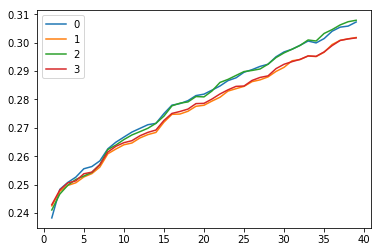

In [15]:
a=show_valid(0)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l3_3000_ridge_fold{}_False_d478.pkl
l3_3003_conv_fold{}_False_d478.pkl
l3_3006_xgb_fold{}_False_d478.pkl
l3_3001_lgb_fold{}_False_d478.pkl
{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


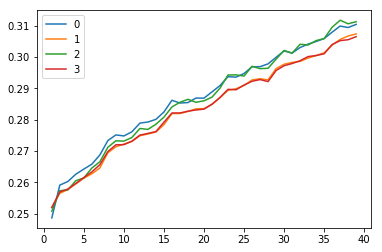

In [16]:
a=show_valid(1)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l3_3000_ridge_fold{}_False_d478.pkl
l3_3003_conv_fold{}_False_d478.pkl
l3_3006_xgb_fold{}_False_d478.pkl
l3_3001_lgb_fold{}_False_d478.pkl
{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


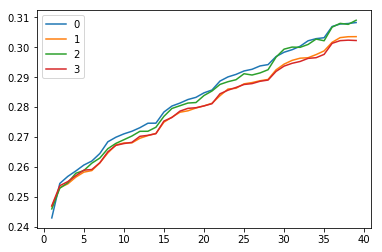

In [17]:
a=show_valid(2)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l3_3000_ridge_fold{}_False_d478.pkl
l3_3003_conv_fold{}_False_d478.pkl
l3_3006_xgb_fold{}_False_d478.pkl
l3_3001_lgb_fold{}_False_d478.pkl
{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


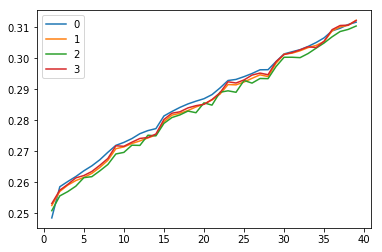

In [18]:
a=show_valid(3)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l3_3000_ridge_fold{}_False_d478.pkl
l3_3003_conv_fold{}_False_d478.pkl
l3_3006_xgb_fold{}_False_d478.pkl
l3_3001_lgb_fold{}_False_d478.pkl
{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


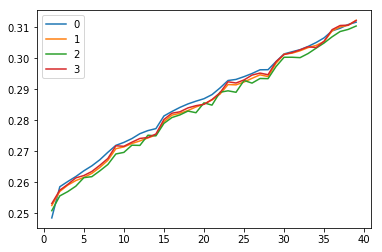

In [19]:
aa=show_valid(4)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [20]:
def get_data_wo_fold():
    d={}
    for fname in pkldata.keys():
        d[fname]={}
        for offset in range(1,40):
            lst1=[];lst2=[]
            for fold in range(5):
                validdf,testdf=get_valid_data(fname,offset,fold,return_test=True)
                lst1.append(validdf)
                lst2.append(testdf)
            validdf=pd.concat(lst1)
            testdf=pd.concat(lst2)
            if np.random.random()<0.2:
                print fname,offset,validdf.shape, validdf.dropna().shape, testdf.shape
            d[fname][offset]=[validdf.dropna(),testdf]
    return d
pkdata_wo_fold=get_data_wo_fold()

l3_3000_ridge_fold{}_False_d478.pkl 7 (249239, 2) (249239, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 11 (248225, 2) (248225, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 21 (245580, 2) (245580, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 22 (245292, 2) (245292, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 27 (244019, 2) (244019, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 34 (242159, 2) (242159, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 35 (241895, 2) (241895, 2) (4145, 1)
l3_3000_ridge_fold{}_False_d478.pkl 38 (241104, 2) (241104, 2) (4145, 1)
l3_3003_conv_fold{}_False_d478.pkl 2 (245003, 2) (245003, 2) (4145, 1)
l3_3003_conv_fold{}_False_d478.pkl 4 (244558, 2) (244558, 2) (4145, 1)
l3_3003_conv_fold{}_False_d478.pkl 6 (244019, 2) (244019, 2) (4145, 1)
l3_3003_conv_fold{}_False_d478.pkl 7 (243738, 2) (243738, 2) (4145, 1)
l3_3003_conv_fold{}_False_d478.pkl 14 (241895, 2) (241895, 2) (4145, 1)
l3_3003_conv_fold{}_False_d478.pkl 16 (241318, 2) (241318, 2)

In [21]:
def MSE(y,ypred):
    ind= (~np.isnan(y)) & (~np.isnan(ypred))
    y=y[ind]
    ypred=ypred[ind]
    return mean_squared_error(y,ypred)
def make_l2_features_by_model(filename, pkdata_wo_fold,offset):
    lst1=[];lst2=[]
    for fold in range(5):
        validdf,testdf=get_valid_data(filename,offset,fold,return_test=True)
        lst1.append(validdf)
        lst2.append(testdf)
    valid=pd.concat(lst1)
    #print valid.columns
    y=valid['ytrue'].values
    valid=valid.drop('ytrue',axis=1)
    print filename, MSE(y,valid.iloc[:,0].values)
    test=reduce(lambda u,v: u+v,lst2)/len(lst2)
    test['idx']=test.index.map(lambda u: tuple([u,478]))
    test=test.set_index('idx')
    total=pd.concat([valid,test])
    arr=np.zeros([829,517],dtype=np.float32)*np.nan
    #print total.index
    index=total.index.map(lambda u: tuple([u[0],u[1]+offset-1]))
    arr[zip(*index)]=total.iloc[:,0].values
    return arr
def make_l2_features(pkdata_wo_fold,offset):
    cols=list(pkdata_wo_fold.keys())
    lst=[]
    for col in cols:
        arr=make_l2_features_by_model(col,pkdata_wo_fold,offset)
        lst.append(arr)
    return cols, np.array(lst)


In [22]:
for offset in range(1,40):
    print offset,
    a,b=make_l2_features( pkdata_wo_fold,offset)
    np.savez_compressed("../input/l3_prediction_offset{}.npz".format(offset),columns=a,arr=b)

1 l3_3000_ridge_fold{}_False_d478.pkl 0.243742
l3_3003_conv_fold{}_False_d478.pkl 0.246404169047
l3_3006_xgb_fold{}_False_d478.pkl 0.248051
l3_3001_lgb_fold{}_False_d478.pkl 0.247718517725
2 l3_3000_ridge_fold{}_False_d478.pkl 0.254327
l3_3003_conv_fold{}_False_d478.pkl 0.252341097705
l3_3006_xgb_fold{}_False_d478.pkl 0.2531
l3_3001_lgb_fold{}_False_d478.pkl 0.252547033375
3 l3_3000_ridge_fold{}_False_d478.pkl 0.256506
l3_3003_conv_fold{}_False_d478.pkl 0.254294520513
l3_3006_xgb_fold{}_False_d478.pkl 0.255034
l3_3001_lgb_fold{}_False_d478.pkl 0.25450247641
4 l3_3000_ridge_fold{}_False_d478.pkl 0.258121
l3_3003_conv_fold{}_False_d478.pkl 0.256493324359
l3_3006_xgb_fold{}_False_d478.pkl 0.256498
l3_3001_lgb_fold{}_False_d478.pkl 0.256047690332
5 l3_3000_ridge_fold{}_False_d478.pkl 0.260429
l3_3003_conv_fold{}_False_d478.pkl 0.257923703464
l3_3006_xgb_fold{}_False_d478.pkl 0.258331
l3_3001_lgb_fold{}_False_d478.pkl 0.257693749245
6 l3_3000_ridge_fold{}_False_d478.pkl 0.261545
l3_3003_con

In [23]:
str(a)

"['l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl']"

In [24]:
#c=make_l2_features_by_model('3001_lgb_fold{}_False_d478.pkl', pkdata_wo_fold,2)

In [25]:
def show_valid():
    d={}
    for fname in pkdata_wo_fold.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=pkdata_wo_fold[fname][offset]
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

l3_3000_ridge_fold{}_False_d478.pkl
l3_3003_conv_fold{}_False_d478.pkl
l3_3006_xgb_fold{}_False_d478.pkl
l3_3001_lgb_fold{}_False_d478.pkl
{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


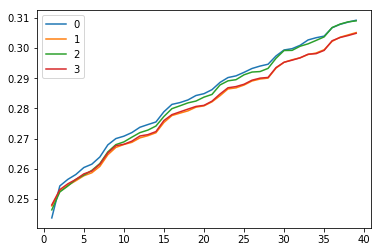

In [26]:
aa=show_valid()
df=pd.DataFrame(aa)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [27]:
def get_valid_pred(offset):
    lst=[]
    for fname in pkdata_wo_fold:
        s=pkdata_wo_fold[fname][offset][0]
        lst.append(s)
    df=pd.concat(lst,axis=1)
    return df

In [28]:
def evaluate(offset):
    a=get_valid_pred(offset)
    a=a.dropna()
    X=a[[u for u in a.columns if u<>'ytrue']].values
    y=a['ytrue'].iloc[:,0].values
    W=rrvf.make_weights(X.T,y,np.ones_like(y))
    return dict(zip([u for u in a.columns if u<>'ytrue'],W))


In [29]:
lst={}
for offset in range(1,40):
    print offset
    lst[offset]=evaluate(offset)

1
individual loss [ 0.24243105  0.24640417  0.2466833   0.24638769]
[  1.00000000e+00   0.00000000e+00  -1.01818110e-16   0.00000000e+00] 0.242431045007
2
individual loss [ 0.25296228  0.2523411   0.2518758   0.25132361]
[ 0.22942407  0.33776673  0.10162096  0.33118824] 0.250023358293
3
individual loss [ 0.25521344  0.25429452  0.25377751  0.25327773]
[ 0.18828959  0.34914446  0.13733459  0.32523137] 0.252011390061
4
individual loss [ 0.25710151  0.25649332  0.25550537  0.2550578 ]
[ 0.18015132  0.31512627  0.16893628  0.33578612] 0.253892927046
5
individual loss [ 0.2593717   0.2579237   0.25735305  0.25676443]
[ 0.11831722  0.35998391  0.11196989  0.40972897] 0.255593181263
6
individual loss [ 0.26056453  0.2594894   0.25839314  0.25786661]
[ 0.11588529  0.31951063  0.15563107  0.40897301] 0.256867618293
7
individual loss [ 0.26285987  0.26175396  0.26051272  0.25987246]
[ 0.11988442  0.30979013  0.11630708  0.45401837] 0.258882915661
8
individual loss [ 0.26677699  0.2656237   0.264

{0: 'l3_3000_ridge_fold{}_False_d478.pkl', 1: 'l3_3001_lgb_fold{}_False_d478.pkl', 2: 'l3_3003_conv_fold{}_False_d478.pkl', 3: 'l3_3006_xgb_fold{}_False_d478.pkl'}


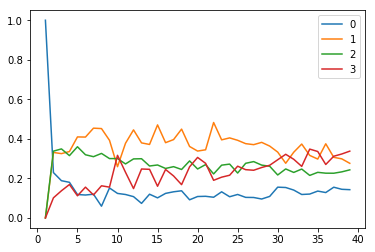

In [30]:
df=pd.DataFrame(lst).T
print dict(enumerate(df.columns))
df.columns=range(df.shape[1])
df.plot()